## MoA prediction

Summary of MoA predictions, including:
- F1 score per representation (Fig 3C in the paper)
- F1 score per MoA (Fig 3D in the paper)
- F1 score vs. number of samples (Supplementary Fig 6)

In [206]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
# sys.path.insert(0, '../') 
# print(sys.path)
from data_layer.data_utils import *
from utils.global_variables import ABRVS
from scripts.classify_moa import get_moa_dirname,exp_results_to_csv

In [208]:

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='CDRP-bio'
# dataset='LINCS'
exp_name = '2003_t'
exp_name = '2752_t'

filter_groups = ['CP', 'anomaly','l1k']
# filter_groups = ['CP','l1k']
ref_filter_groups = ['CP','l1k']
moa_exp_dir = 'MoAprediction2'

tune = True
tune_all_folds = True
normalize_by_all = True

if tune:
    if tune_all_folds:
        tune_str = '-ta'
    else:
        tune_str = '-t'
else:
    tune_str = ''

res_filename=f'pred_moa_res_all'

modality = 'CellPainting'
profile_type='augmented'
folds = 5
rep_corr_fileName='RepCorrDF'


base_dir='/sise/assafzar-group/assafzar/genesAndMorph'
res_dir = f'{base_dir}/results/'
exp_dir = f'{base_dir}/results/{dataset}/{modality}/{exp_name}'
moa_exp_dir = f'{exp_dir}/{moa_exp_dir}/'

data_dir = f'{base_dir}/anomaly_output/{dataset}/CellPainting/{exp_name}' 


nSamplesMOA = 4 
by_dose = False

profTypeAbbrev=''.join([s[0] for s in profile_type.split('_')])
Types = ['ae_diff', 'baseline']
profileTypes = [f'{profile_type}_{t}' for t in Types]
profTypeAbbrev = [ABRVS[p] for p in profileTypes]

profiles = {}
for p in profileTypes:
    profiles[p] = {}
    profiles[p]['cp_path'] = os.path.join(data_dir,f'replicate_level_cp_{p}.csv')
    
# filename='../../results/RepCor/'+fileName+'.xlsx'
# os.makedirs(procProf_dir,exist_ok=True)

In [209]:
moa_csv_dirname, exp_suffix, filter_abrv = get_moa_dirname(profile_type, by_dose, filter_groups, folds, nSamplesMOA, normalize_by_all)

save_dir = os.path.join(moa_exp_dir,moa_csv_dirname)

exp_results_to_csv(exp_dir, moa_csv_dirname, filename=res_filename)

fig_dir = f'{moa_exp_dir}/figures/'
# os.makedirs(save_dir,exist_ok=True)
os.makedirs(fig_dir,exist_ok=True)
save_dir

'/sise/assafzar-group/assafzar/genesAndMorph/results/CDRP-bio/CellPainting/2752_t/MoAprediction2/augmented_n4_f5_a_ba_cal'

## Visualize the results

In [210]:
moa_csv_dirname

'augmented_n4_f5_a_ba_cal'

In [211]:
filename = f'{save_dir}/{res_filename}.xlsx'
saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
sgkf_keys_all = saved_scores_cdrpbio.keys()

In [212]:
sgkf_keys_all

dict_keys(['Anomaly-lr-ta', 'Anomaly-mlp-ta', 'CellProfiler-lr-ta', 'CellProfiler-mlp-ta', 'fuse-lr-ta', 'fuse-mlp-ta'])

In [213]:

# saved_scores_cdrpbio[sgkf_keys[0]]
# sgkf_keys
# methods.keys()
sgkf_keys = []
if tune:
    sgkf_keys = [s for s in sgkf_keys_all if '-t'  in s]
    if tune_all_folds:
        sgkf_keys = [s for s in sgkf_keys_all if '-ta'  in s]
    else:
        sgkf_keys = [s for s in sgkf_keys_all if not '-ta'  in s]
else:
    sgkf_keys = [s for s in sgkf_keys_all if not '-t'  in s]
sgkf_keys

['Anomaly-lr-ta',
 'Anomaly-mlp-ta',
 'CellProfiler-lr-ta',
 'CellProfiler-mlp-ta',
 'fuse-lr-ta',
 'fuse-mlp-ta']

In [214]:
for key in saved_scores_cdrpbio.keys():
    print('num values for {key} is {num}'.format(key=key,num=saved_scores_cdrpbio[key].shape[0]))
# saved_scores_cdrpbio['raw_a-lr'].shape

num values for Anomaly-lr-ta is 1390
num values for Anomaly-mlp-ta is 1390
num values for CellProfiler-lr-ta is 1390
num values for CellProfiler-mlp-ta is 1390
num values for fuse-lr-ta is 1390
num values for fuse-mlp-ta is 1390


In [215]:
def compute_f1(df,model_name,data_type,e,f=None):
    # f1 = f1_score(df['Metadata_moa_num'].tolist(),df['Late Fusion'].tolist(), average='weighted')
    # df = df.rename(columns={'GE':'L1000','CP':'CellPainting','Late Fusion':'CellPainting+L1000'})
    df = df.rename(columns={'GE':'L1000','CP':'-L1000','Late Fusion':'+L1000'})
    # , 'Early Fusion': 'CellPainting+L1000'},inplace=True)
    modalities= ['-L1000','+L1000']
    modalities= ['L1000', '-L1000','+L1000']

    # output_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
    output_df = pd.DataFrame([])

    for dd in modalities:
        scor_vals=df[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        # print(f'data type: {data_type}, model: {model_name}, modality: {dd}, fold: {f}')
        f1_macro=f1_score(scor_vals,df.Metadata_moa_num.values, average='macro')
        f1_weighted=f1_score(scor_vals,df.Metadata_moa_num.values, average='weighted')

        if f is not None:
            temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': [model_name],'F1-macro':[f1_macro],'F1-weighted':[f1_weighted],'Type':[data_type],'Fold':[f],'exp_num':[e]})
        else:
            temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': [model_name],'F1-macro':[f1_macro],'F1-weighted':[f1_weighted],'Type':[data_type],'exp_num':[e]})
        output_df = pd.concat([output_df,temp_df])
    return output_df

def concat_model_scores(df,model_name='MLP',data_type='AE'):
    # methods= ['CP', 'GE', 'Early Fusion','Late Fusion']
    folds=df['Fold'].unique().tolist()
    exps = df['exp_num'].unique().tolist()
    res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num'])
    res_df_fold_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
    for e in exps:
        df_e = df[df['exp_num']==e]
        temp_df = compute_f1(df_e,model_name,data_type,e)
        res_df_exp_level=pd.concat([res_df_exp_level,temp_df])
        # res_df_by_exp
        for f in folds:
            df_f=df_e[df_e['Fold']==f]
            temp_df = compute_f1(df_f,model_name,data_type,e,f)
            res_df_fold_level=pd.concat([res_df_fold_level,temp_df])
                    #    ,'RGCCA_EarlyFusion']:
                
                # res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
                
    return res_df_fold_level, res_df_exp_level       


In [216]:
sgkf_keys

['Anomaly-lr-ta',
 'Anomaly-mlp-ta',
 'CellProfiler-lr-ta',
 'CellProfiler-mlp-ta',
 'fuse-lr-ta',
 'fuse-mlp-ta']

In [217]:
from sklearn.metrics import f1_score
#########################################################
res_df =pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','Fold','exp_num'])

# DS='CDRP-bio'
# scores_mlp=saved_scores_cdrpbio[DS+'-nvs-mlp-ht-sgkf-10f']
# scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp['mofa']=mofa_scores_2add['mofa']
reps = ['CellProfiler', 'Anomaly', 'Fusion']
methods = ['lr', 'mlp']

# res_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
for i ,k in enumerate(sgkf_keys):
    # data_representation = k.split('-')[0]
    # m = methods[i]
    if 'Anomaly' in k:
        data_representation = reps[1]
    elif 'CellProfiler' in k: 
        data_representation = reps[0]
    else:
        data_representation= reps[2]

    if 'mlp' in k:
        model = 'MLP'
    elif 'lr' in k: 
        model = 'LR'
    elif 'xgboost' in k:
        model = 'XGBoost'
    print(model)
    print(data_representation)
    res_df_method, res_df_exp_level_method = concat_model_scores(saved_scores_cdrpbio[k], model,data_type = data_representation) 
    res_df = pd.concat([res_df,res_df_method])
    res_df_exp_level = pd.concat([res_df_exp_level,res_df_exp_level_method])
    
n_classes = saved_scores_cdrpbio[k].Metadata_moa_num.nunique()


LR
Anomaly
MLP
Anomaly
LR
CellProfiler
MLP
CellProfiler
LR
Fusion


MLP
Fusion


In [218]:
# saved_scores_cdrpbio[k]

In [219]:
saved_scores_cdrpbio.keys()

dict_keys(['Anomaly-lr-ta', 'Anomaly-mlp-ta', 'CellProfiler-lr-ta', 'CellProfiler-mlp-ta', 'fuse-lr-ta', 'fuse-mlp-ta'])

In [220]:

sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":16,"axes.labelsize":16})
pallete= "Set2"
sns.color_palette(pallete)
sns.set(style="whitegrid", palette=pallete)

In [221]:
# res_df_cdrpbio
import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# pallete2 = sns.color_palette("Set2")
# pallete2
pallete3 = [sns.color_palette("Set2")[1],sns.color_palette("Set2")[0],sns.color_palette("Set2")[2]]
# palette
sns.set(style="whitegrid", palette=pallete3)
# sns.set_style("whitegrid")
methods = ['AnomalyCP','CP']
models = ['LR','MLP','XGBoost']
models = ['LR','MLP']
hue_order = ['CellProfiler','Anomaly', 'Fusion']

Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']

In [222]:
res_df_grouped_folds = res_df.groupby(['Model','Modality','Type','exp_num']).mean().reset_index()

# sns.set_style("whitegrid")
# fig,axes=plt.subplots(1,1,figsize=(5,5),sharey=True)
methods = ['CellProfiler','Anomaly', 'Fusion']
methods = ['CellProfiler','Anomaly']
hue_order = methods
models = ['LR','MLP']
# Modalities = ['CP', 'GE', 'Early Fusion']
modality = '-L1000'


In [223]:
res_df_grouped_folds.sort_values(by='F1-weighted',ascending=True,inplace=True)

In [224]:
# filter out methods not inspected
res_df_grouped_folds = res_df_grouped_folds[res_df_grouped_folds['Type'].isin(methods)].reset_index(drop=True)
# res_df_grouped_folds

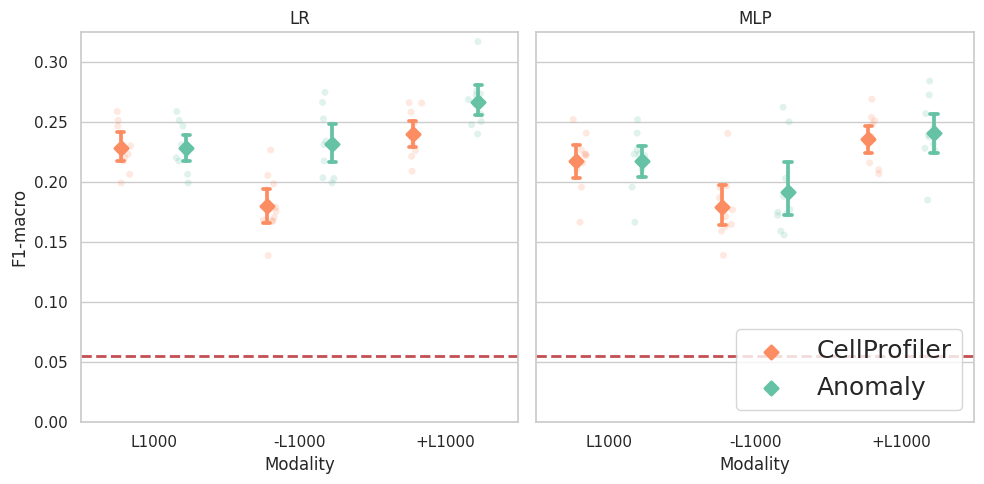

In [225]:
from utils.global_variables import methods_colors_list_for_moa
# methods = ['AnomalyCP','CP']
# models = ['LR','MLP']
order = ['L1000','-L1000', '+L1000']

metric = 'F1-macro'
# Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    # sns.boxplot(x="Modality", y=metric, hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)

    sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, 
    order = order
)

    sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, 
    order = order
    # markerssize=20, markersedgewidth=3,
)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,max_val+0.05)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
    axes[i].legend(loc = 'lower right', fontsize = 18)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='lower right', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'stripplot_all_modalities_bar_{moa_csv_dirname}_{metric}.png')
plt.savefig(save_path,dpi=500)

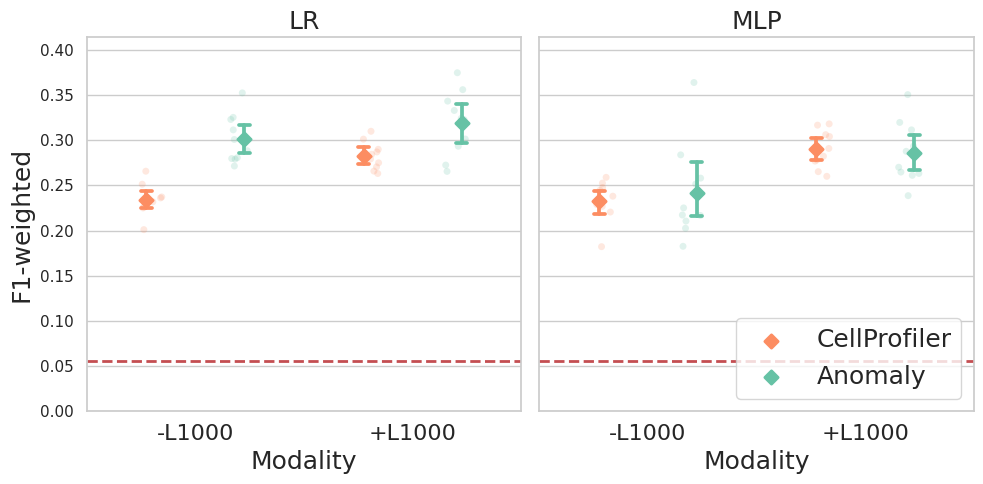

In [226]:
order = ['-L1000', '+L1000']
metric = 'F1-weighted'
# Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    # sns.boxplot(x="Modality", y=metric, hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)

    sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, 
    # order = ['L1000','CP', 'CP+L1000']
    order = order
)

    sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, 
    # order = ['L1000','CP', 'CP+L1000']
    order = order

    # markerssize=20, markersedgewidth=3,
)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,max_val+0.05)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p, fontsize=18)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
    # g.legend(loc = 'lower right', borderaxespad=0, fontsize=16)

    # set font size for labels 
    axes[i].set_xlabel(axes[i].get_xlabel(),fontsize=18)
    axes[i].set_ylabel(axes[i].get_ylabel(),fontsize=18)
    axes[i].set_xticklabels(axes[i].get_xticklabels(),fontsize=16)
    axes[i].legend(fontsize=18,loc = 'lower right')

    
# plt.legend(bbox_to_anchor=(0.27, 1), loc='lower right', borderaxespad=0)
axes[0].legend([],[], frameon=False, fontsize=20, loc='lower right')
plt.tight_layout()
save_path = os.path.join(fig_dir,f'stripplot_all_modalities_bar_{moa_csv_dirname}_{metric}.png')
plt.savefig(save_path,dpi=500)

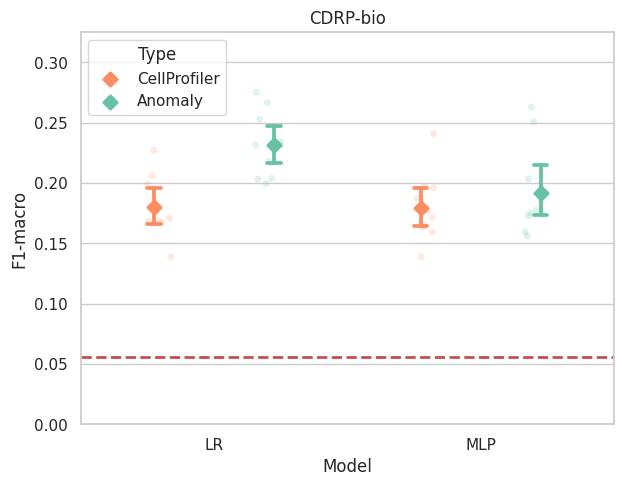

In [227]:
# res_df_grouped_folds.groupby(['Model','Modality','Type'])['F1-macro'].describe()
# res_df_grouped_folds
metric = 'F1-macro'
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, order = ['LR','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, order = ['LR','MLP']
    # markerssize=20, markersedgewidth=3,
)
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# g.legend( loc='lower right', borderaxespad=0)
# g.legend(loc='upper right', bbox_to_anchor=(0.6, 0.1))
# g.legend(loc='upper right')

# g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)

g.set_ylim(0,max_val+0.05)
plt.tight_layout()
plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_dirname}.png')
plt.savefig(save_path,dpi=500)

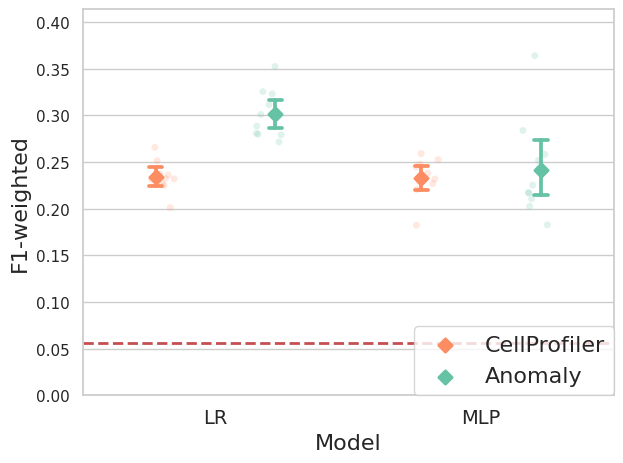

In [228]:
########### w/o Fusion #############
metric = 'F1-weighted'

res_df_grouped_folds_no_fusion = res_df_grouped_folds[res_df_grouped_folds['Type']!='Fusion']

max_val = res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=['CellProfiler', 'Anomaly'], order = ['LR','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D",hue_order=['CellProfiler', 'Anomaly'], order = ['LR','MLP']
    # markerssize=20, markersedgewidth=3,
)
# g = sns.barplot(
#     data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
#     errorbar=("pi", 50), capsize=.1,
#     # err_kws={"color": ".5", "linewidth": 2.5},
#     # linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
# )
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.set_ylim(0,max_val+0.05)
g.legend(loc = 'lower right', borderaxespad=0, fontsize=16)

# set font size for labels 
g.set_xlabel(g.get_xlabel(),fontsize=16)
g.set_ylabel(g.get_ylabel(),fontsize=16)
g.set_xticklabels(g.get_xticklabels(),fontsize=14)
# plt.ylabel(fontsize=16)
# plt.xticks(fontsize=16)
plt.tight_layout()
# plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_dirname}_no_fusion.png')
plt.savefig(save_path,dpi=500)

LR
10
10
Welch's t-test results:
t-statistic: 4.501157599828635
p-value: 0.00028021824010637407


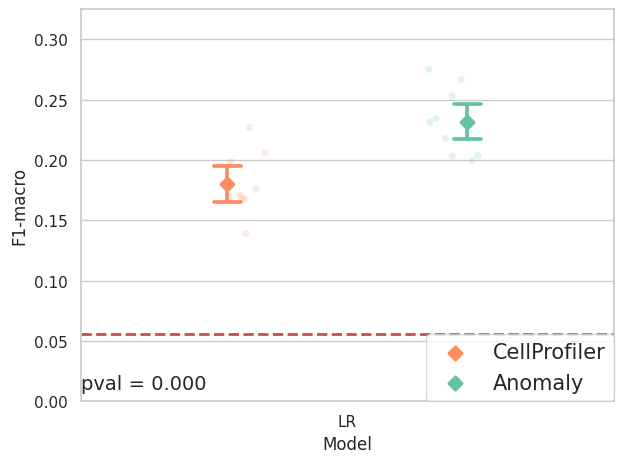

MLP
10
10
Welch's t-test results:
t-statistic: 0.8459273248401243
p-value: 0.409495565035479


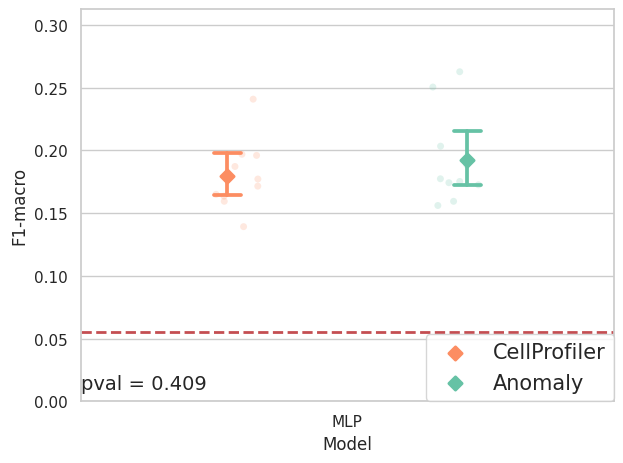

Welch's t-test results:
t-statistic: 4.272969125551767
p-value: 0.0004594806017739485
LR
10
10
Welch's t-test results:
t-statistic: 6.834780704929192
p-value: 4.981375916640046e-06


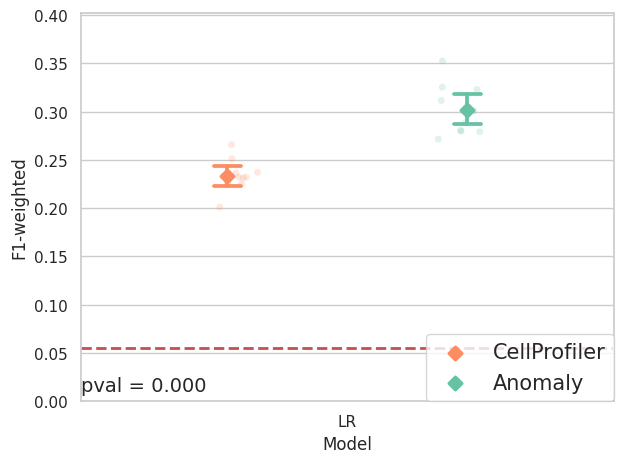

MLP
10
10
Welch's t-test results:
t-statistic: 0.44856950285203845
p-value: 0.6617311996854731


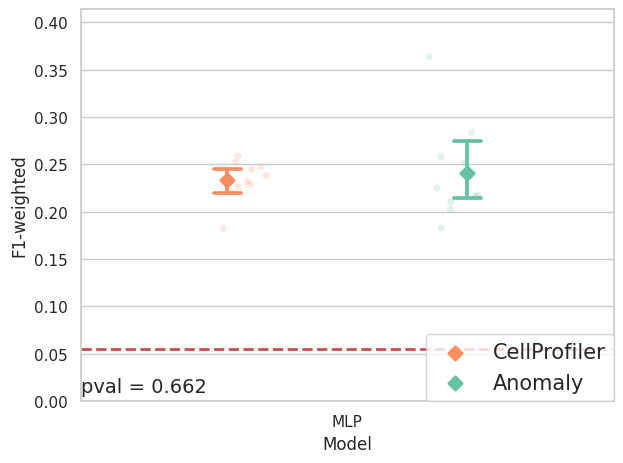

Welch's t-test results:
t-statistic: 6.3222347787920805
p-value: 6.918644493273126e-06


<Figure size 640x480 with 0 Axes>

In [229]:
########### only MLP #############
from scipy.stats import ttest_ind


metrics = ['F1-macro','F1-weighted']
for metric in metrics:
    for model in models:
        print(model)
        res_df_grouped_folds_mlp = res_df_grouped_folds[(res_df_grouped_folds['Model']==model) & (res_df_grouped_folds["Modality"]==modality)]

        # metric = 'F1-weighted'
        max_val = res_df_grouped_folds_mlp.groupby(['Model','Type'])[metric].max().max()

        sns.stripplot(
            data=res_df_grouped_folds_mlp, x="Model", y=metric, hue="Type",
            dodge=True, alpha=.2, legend=False,hue_order=['CellProfiler', 'Anomaly'],
        )
        g =sns.pointplot(
            data=res_df_grouped_folds_mlp, x="Model", y=metric, hue="Type",
            dodge=.45, 
            linestyles="none", 
            errorbar=("ci", 95), capsize=.05,
            markers="D",hue_order=['CellProfiler', 'Anomaly']
            # markerssize=20, markersedgewidth=3,
        )

        g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
        g.legend(loc = 'lower right', borderaxespad=0, fontsize=15)
        g.set_ylim(0,max_val+0.05)

        # Extract the data for 'CellProfiler' and 'Anomaly'
        data_cellprofiler = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'CellProfiler'][metric]
        data_anomaly = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'Anomaly'][metric]

        print(len(data_cellprofiler))
        print(len(data_anomaly))
        
        # Perform Welch's t-test
        t_stat, p_value = ttest_ind(data_anomaly,data_cellprofiler, equal_var=False)

        # Print the results
        print("Welch's t-test results:")
        print(f"t-statistic: {t_stat}")
        print(f"p-value: {p_value}")


        plt.tight_layout()
        # plt.title(f'{dataset}_pval = {p_value:.3f}')
        plt.text(-0.5, 0.01, f'pval = {p_value:.3f}', fontsize=14)
        save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_dirname}_{model}_only.png')
        plt.show()
        plt.savefig(save_path,dpi=500)
        # plt.close()

    # calc p_value between different models
    data_anomaly = res_df_grouped_folds[(res_df_grouped_folds['Model']=='LR') & (res_df_grouped_folds["Modality"]==modality) & (res_df_grouped_folds['Type']=='Anomaly')][metric]
    data_cellprofiler = res_df_grouped_folds[(res_df_grouped_folds['Model']=='MLP') & (res_df_grouped_folds["Modality"]==modality) & (res_df_grouped_folds['Type']=='CellProfiler')][metric]
    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(data_anomaly,data_cellprofiler, equal_var=False)

    # Print the results
    print("Welch's t-test results:")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")




In [230]:
# print average F1-score for each model
res_df_grouped_folds.groupby(['Model','Type','Modality'])['F1-macro'].mean()
# res_df_grouped_folds.groupby(['Model','Type'])['F1-weighted'].mean()


Model  Type          Modality
LR     Anomaly       +L1000      0.266869
                     -L1000      0.231591
                     L1000       0.228699
       CellProfiler  +L1000      0.240645
                     -L1000      0.180013
                     L1000       0.228699
MLP    Anomaly       +L1000      0.241069
                     -L1000      0.191896
                     L1000       0.217898
       CellProfiler  +L1000      0.236320
                     -L1000      0.179588
                     L1000       0.217898
Name: F1-macro, dtype: float64

In [231]:
res_df_grouped_folds.groupby(['Model','Type','Modality'])['F1-weighted'].mean()


Model  Type          Modality
LR     Anomaly       +L1000      0.318713
                     -L1000      0.301286
                     L1000       0.248498
       CellProfiler  +L1000      0.282685
                     -L1000      0.233792
                     L1000       0.248498
MLP    Anomaly       +L1000      0.286120
                     -L1000      0.241246
                     L1000       0.249702
       CellProfiler  +L1000      0.289921
                     -L1000      0.233221
                     L1000       0.249702
Name: F1-weighted, dtype: float64

running for mlp
['Anomaly-mlp-ta', 'CellProfiler-mlp-ta', 'fuse-mlp-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 18
number of classes with F1-score higher than random: 18


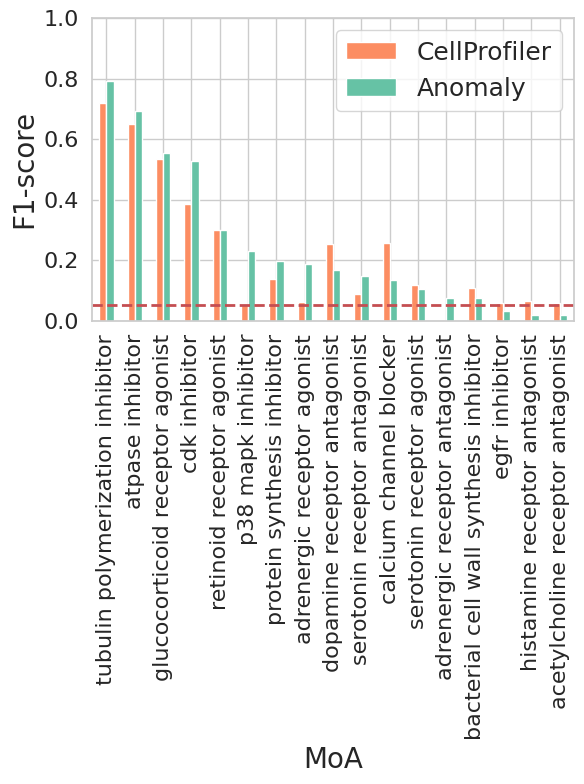

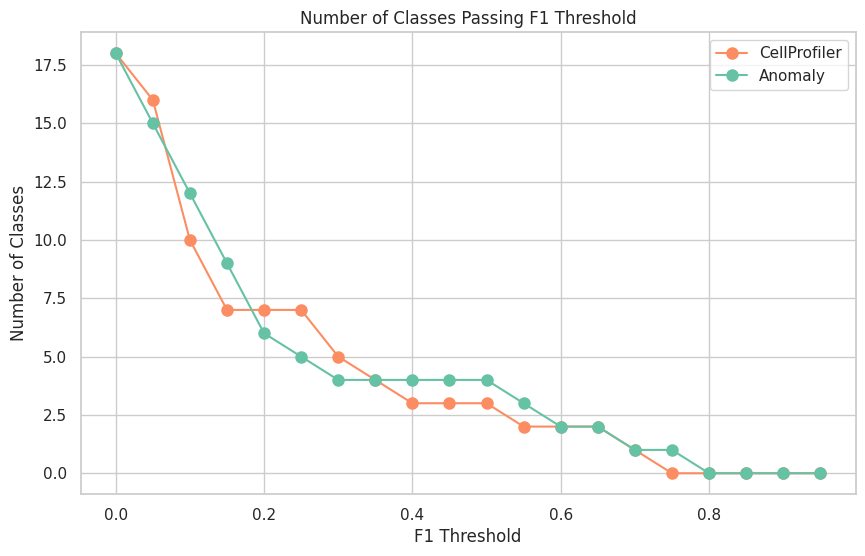

running for lr
['Anomaly-lr-ta', 'CellProfiler-lr-ta', 'fuse-lr-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 18
number of classes with F1-score higher than random: 18


<Figure size 640x480 with 0 Axes>

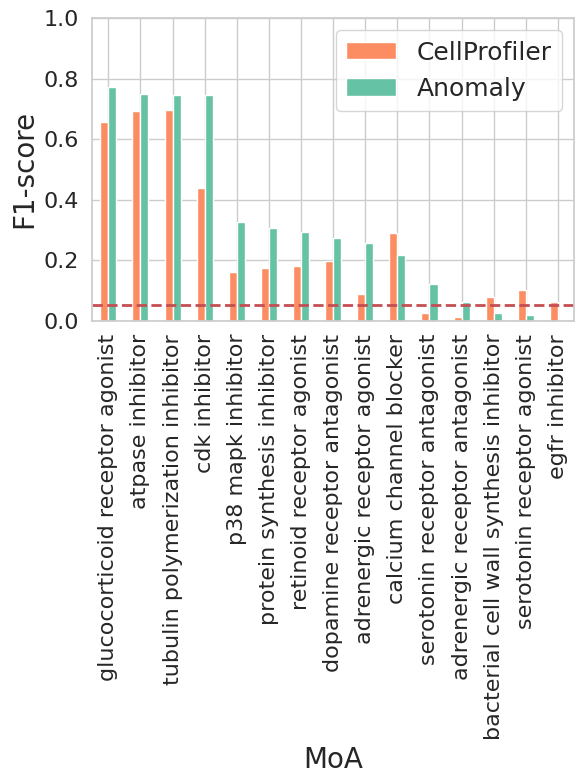

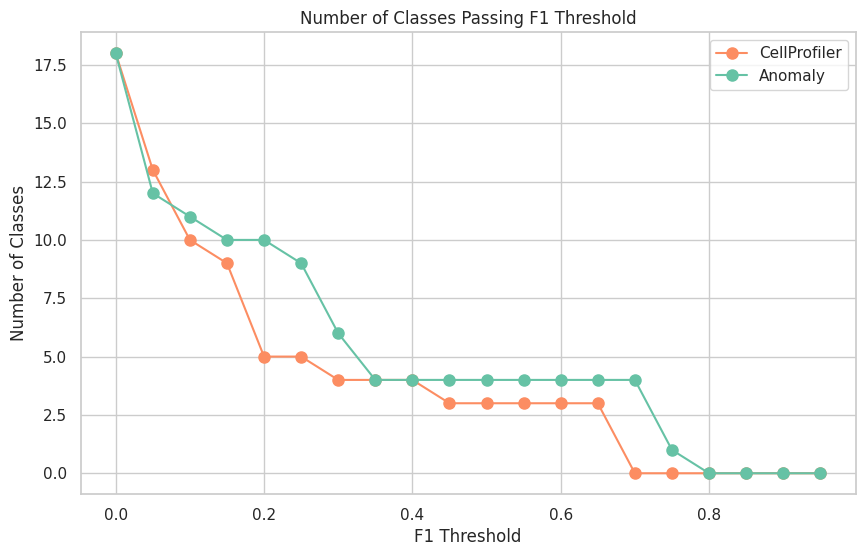

<Figure size 640x480 with 0 Axes>

In [232]:
from sklearn.metrics import classification_report
from utils.global_variables import methods_colors_list_for_moa

with_fusion = False

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:

    print(f'running for {model}')
    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'Anomaly' in k:
            rep = 'Anomaly'
        elif 'CellProfiler' in k:
            rep = 'CellProfiler'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        scores_model = saved_scores_cdrpbio[k]
        scores[rep] = scores_model['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())
    # # 2. reformat scores to be able to use classification report


    # scores_mlp = pd.concat(saved_scores_cdrpbio[mlp_keys])
    # scores_mlp=res_df[(res_df["Modality"]=="CP") & (res_df["Model"]=="MLP")]
    # scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

    # scor_vals_ae=scores_mlp['AE_pred'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_raw=scores_mlp['CellProfiler'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err=scores_mlp['Anomaly'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    if with_fusion:
        scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    if with_fusion:
        report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err.index[0:n_classes]:
        report_clss_ae_err.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err[0:n_classes]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    if with_fusion:
        report_clss3['f1-score-fuse']=report_clss_fuse.loc[report_clss3.index]['f1-score'].values
    # report_clss3['f1-score-ae_err']=report_clss_ae_err.loc[report_clss3.index]['f1-score'].values

    # report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
    # report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-ae_err']]
    if with_fusion:
        report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]
    else:
        report_clss4=report_clss3[['f1-score-raw','f1-score']]
        
    report_clss4=report_clss4.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly','f1-score-fuse':'Fusion'})
    report_clss4.index=report_clss3['MoA']

    rand_f1_score = (1/n_classes)/ ( (1-1/n_classes) + 1/n_classes + 1/n_classes)
    print(f'n_classes: {len(report_clss4)}')

    report_clss5 = report_clss4[(report_clss4['CellProfiler']>=rand_f1_score) | (report_clss4['Anomaly']>=rand_f1_score)]
    print(f'number of classes with F1-score higher than random: {len(report_clss4)}')

    # ax = report_clss4.plot.bar(rot=90,figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    ax = report_clss5.plot.bar(rot=90,figsize=(int(n_classes/3),8),fontsize=16,linewidth=1)

    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)

    # plt.title(f'{dataset} class specific F1-scores ({model})')
    plt.legend(loc='upper right', fontsize=18)
    plt.ylabel('F1-score', fontsize=20)
    plt.xlabel('MoA', fontsize=20)
    ax.set_ylim([0,1])
    ax.axhline(y=rand_f1_score,linestyle='--',color='r',linewidth=2)
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_dirname}.png')
    plt.savefig(save_path,dpi=500)
    # plt.close()

    # a graph showing the number of classes that pass the F1 threshold vs. the F1 threshold
    plt.figure(figsize=(10, 6))
    x = np.arange(0, 1, 0.05)

    do_plot = True
    if do_plot:
        # Plotting the graph
        plt.plot(x, [len(report_clss4[report_clss4['CellProfiler'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler')
        plt.plot(x, [len(report_clss4[report_clss4['Anomaly'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly')
        # plt.axhline(y=1/n_classes, color='red', linestyle='--')

        # Customize the plot
        plt.xlabel('F1 Threshold')
        plt.ylabel('Number of Classes')
        plt.title('Number of Classes Passing F1 Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(fig_dir, f'num_classes_passing_f1_threshold_{model}_{moa_csv_dirname}.png'), dpi=500)
    # if 1:
    #     source_data_add='../Figs_Source_Data.xlsx'
    #     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    #     # fig.tight_layout()
    #     plt.savefig('fig4c_1.pdf',dpi=500)

In [233]:
n_classes

18

In [234]:
metric = 'f1-score'
# f1_thresh = 0.1
print(f'f1-score threshold: {rand_f1_score}')
# (report_clss_raw[metric]>rand_f1_score).sum(), (report_clss_ae_err[metric]>rand_f1_score).sum(),(report_clss_fuse[metric]>rand_f1_score).sum()
(report_clss_raw[metric]>rand_f1_score).sum(), (report_clss_ae_err[metric]>rand_f1_score).sum()

f1-score threshold: 0.05263157894736842


(16, 15)

In [235]:
metric = 'f1-score'
f1_thresh = 0.2
print(f'f1-score threshold: {f1_thresh}')
# (report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum()

f1-score threshold: 0.2


(8, 13)

In [236]:
metric = 'recall'
f1_thresh = 0.2
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum()
# (report_clss_fuse[metric]>f1_thresh).sum()

(9, 12)

In [237]:
metric = 'precision'
f1_thresh = 0.2
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum()
# ,(report_clss_fuse[metric]>f1_thresh).sum()


(11, 13)

In [238]:
res_filename

'pred_moa_res_all'

In [239]:
moa_csv_dirname_ref, ref_exp_suffix, ref_filter_abrv = get_moa_dirname(profile_type, by_dose, ref_filter_groups, folds, nSamplesMOA, normalize_by_all)

exp_results_to_csv(exp_dir, moa_csv_dirname_ref, filename=res_filename)


save_dir = os.path.join(moa_exp_dir,moa_csv_dirname_ref)
# fig_dir = f'{moa_csv_dirname_ref}/figures/'
# os.makedirs(save_dir,exist_ok=True)
os.makedirs(fig_dir,exist_ok=True)

# moa_exp_dir, exp_suffix, filter_abrv = get_moa_dirname(profile_type, by_dose, ref_filter_groups, folds, nSamplesMOA, normalize_by_all)
# ref_save_dir = os.path.join(save_dir,moa_exp_dir)
moa_csv_path=os.path.join(save_dir,f'pred_moa_res_all.xlsx')
saved_scores_orig=pd.read_excel(moa_csv_path, sheet_name=None)

sgkf_keys_all = saved_scores_orig.keys()

sgkf_keys = []
if tune:
    sgkf_keys = [s for s in sgkf_keys_all if '-t'  in s]
    if tune_all_folds:
        sgkf_keys = [s for s in sgkf_keys_all if '-ta'  in s]
    else:
        sgkf_keys = [s for s in sgkf_keys_all if not '-ta'  in s]
else:
    sgkf_keys = [s for s in sgkf_keys_all if not '-t'  in s]
sgkf_keys


# for key in saved_scores_orig.keys():
    # print('num values for {key} is {num}'.format(key=key,num=saved_scores_cdrpbio[key].shape[0]))
# saved_scores_cdrpbio['raw_a-lr'].shape

['Anomaly-lr-ta',
 'Anomaly-mlp-ta',
 'CellProfiler-lr-ta',
 'CellProfiler-mlp-ta',
 'fuse-lr-ta',
 'fuse-mlp-ta']

running for mlp
['Anomaly-mlp-ta', 'CellProfiler-mlp-ta', 'fuse-mlp-ta']
Index(['Anomaly_ref', 'CellProfiler_ref', 'Fusion_ref', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 13
number of classes with F1-score higher than random: 13


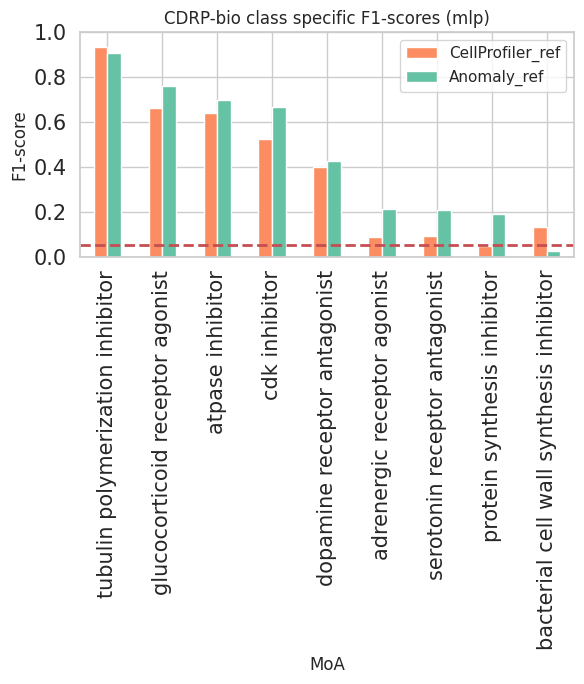

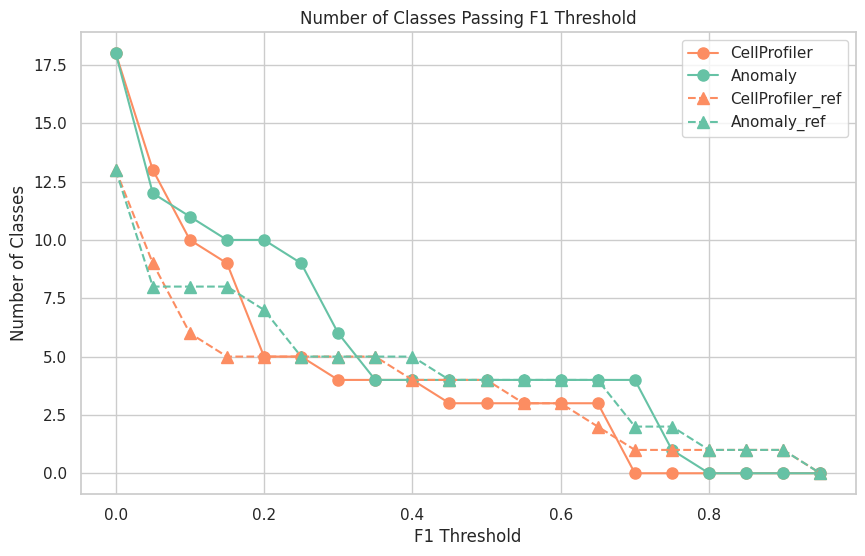

running for lr
['Anomaly-lr-ta', 'CellProfiler-lr-ta', 'fuse-lr-ta']
Index(['Anomaly_ref', 'CellProfiler_ref', 'Fusion_ref', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 13
number of classes with F1-score higher than random: 13


<Figure size 640x480 with 0 Axes>

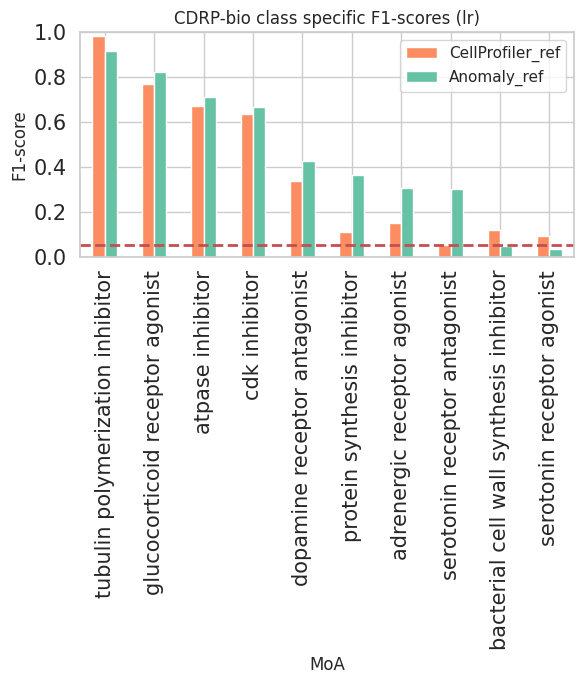

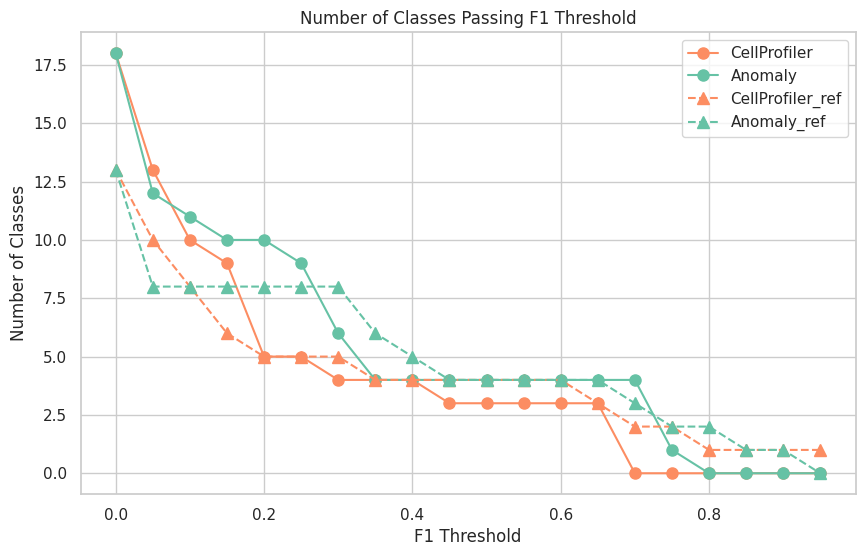

<Figure size 640x480 with 0 Axes>

In [240]:
with_fusion = False
show_both_new_and_ref = False

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:

    print(f'running for {model}')
    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'Anomaly' in k:
            rep = 'Anomaly'
        elif 'CellProfiler' in k:
            rep = 'CellProfiler'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        # scores_model = saved_scores_cdrpbio[k]
        # scores[rep] = scores_model['CP']

        scores_model_ref = saved_scores_orig[k]
        scores[f'{rep}_ref'] = scores_model_ref['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model_ref['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model_ref['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model_ref['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())

    # # 2. reformat scores to be able to use classification report
    n_classes_orig = len(scores_mlp['Metadata_moa_num'].unique())

    scor_vals_raw_ref=scores_mlp['CellProfiler_ref'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err_ref=scores_mlp['Anomaly_ref'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    
    if with_fusion:
        scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    # report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    # report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    report_clss_ae_err_ref=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err_ref.values,output_dict=True)).transpose()
    report_clss_raw_ref=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw_ref.values,output_dict=True)).transpose()
    if with_fusion:
        report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err_ref['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err_ref.index[0:n_classes_orig]:
        report_clss_ae_err_ref.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err_ref[0:n_classes_orig]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    # report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    report_clss3['f1-score-raw-ref']=report_clss_raw_ref.loc[report_clss3.index]['f1-score'].values

    if with_fusion:
        report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]
    else:
        report_clss4_ref=report_clss3[['f1-score-raw-ref','f1-score']]
        
    report_clss4_ref=report_clss4_ref.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly_ref','f1-score-fuse':'Fusion', 'f1-score-raw-ref':'CellProfiler_ref', 'f1-score-ae_err-ref':'Anomaly_ref'})
    report_clss4_ref.index=report_clss3['MoA']

    if show_both_new_and_ref:
        report_class_4_for_ref_plot = report_clss4[report_clss4.index.isin(report_clss4_ref.index)]
        # concat the two dataframes
        report_clss4_ref = pd.concat([report_clss4_ref, report_class_4_for_ref_plot], axis=1)

    rand_f1_score_ref = (1/n_classes_orig)/ ( (1-1/n_classes_orig) + 1/n_classes_orig + 1/n_classes_orig)
    print(f'n_classes: {len(report_clss4_ref)}')
    report_clss5_ref = report_clss4_ref[(report_clss4_ref['CellProfiler_ref']>=rand_f1_score_ref) | (report_clss4_ref['Anomaly_ref']>=rand_f1_score_ref)]
    print(f'number of classes with F1-score higher than random: {len(report_clss4_ref)}')

    # ax = report_clss4_ref.plot.bar(rot=90,figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    ax = report_clss5_ref.plot.bar(rot=90,figsize=(int(n_classes/3),7),fontsize=15,linewidth=1)

    # highlight the x labels of classes that are only in new and not in ref
    if show_both_new_and_ref:
        new_classes = list(set(report_clss_ae_err['MoA']) - set(report_clss_ae_err_ref['MoA']))
        for i, label in enumerate(ax.get_xticklabels()):
            print(label.get_text())
            if label.get_text() in new_classes:
                # print(label.get_text())
                label.set_color('red')
                label.set_fontweight('bold')
        

    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)

    plt.title(f'{dataset} class specific F1-scores ({model})')

    plt.ylabel('F1-score')
    ax.set_ylim([0,1])
    ax.axhline(y=rand_f1_score,linestyle='--',color='r',linewidth=2)
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_dirname}_vs_ref.png')
    plt.savefig(save_path,dpi=500)
    # plt.close()

    # a graph showing the number of classes that pass the F1 threshold vs. the F1 threshold
    plt.figure(figsize=(10, 6))
    x = np.arange(0, 1, 0.05)

    do_plot = True
    if do_plot:
        # Plotting the graph
        plt.plot(x, [len(report_clss4[report_clss4['CellProfiler'] >= f1_threshold]) for f1_threshold in x], marker='o', linestyle='solid', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler')
        plt.plot(x, [len(report_clss4[report_clss4['Anomaly'] >= f1_threshold]) for f1_threshold in x], marker='o' , linestyle='solid', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly')
        plt.plot(x, [len(report_clss4_ref[report_clss4_ref['CellProfiler_ref'] >= f1_threshold]) for f1_threshold in x], marker='^', linestyle='dashed', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler_ref')
        plt.plot(x, [len(report_clss4_ref[report_clss4_ref['Anomaly_ref'] >= f1_threshold]) for f1_threshold in x], marker='^', linestyle='dashed', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly_ref')
        # plt.axhline(y=1/n_classes, color='red', linestyle='--')

        # Customize the plot
        plt.xlabel('F1 Threshold')
        plt.ylabel('Number of Classes')
        plt.title('Number of Classes Passing F1 Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(fig_dir,f'num_classes_passing_f1_threshold_{model}_{moa_csv_dirname} vs. ref.png'),dpi=500)


In [241]:
#classes that are in represetation 1 but not in representation 2
set(report_clss_ae_err.index) - set(report_clss_ae_err_ref.index)

# classes that are in representation 1 but not in representation 2 by MoA label
new_classes = list(set(report_clss_ae_err['MoA']) - set(report_clss_ae_err_ref['MoA']))
new_classes

['egfr inhibitor',
 'dopamine receptor agonist',
 'p38 mapk inhibitor',
 'histamine receptor antagonist',
 'retinoid receptor agonist']

running for mlp
['Anomaly-mlp-ta', 'CellProfiler-mlp-ta', 'fuse-mlp-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 18
number of classes with F1-score higher than random: 17


running for lr
['Anomaly-lr-ta', 'CellProfiler-lr-ta', 'fuse-lr-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 18
number of classes with F1-score higher than random: 15


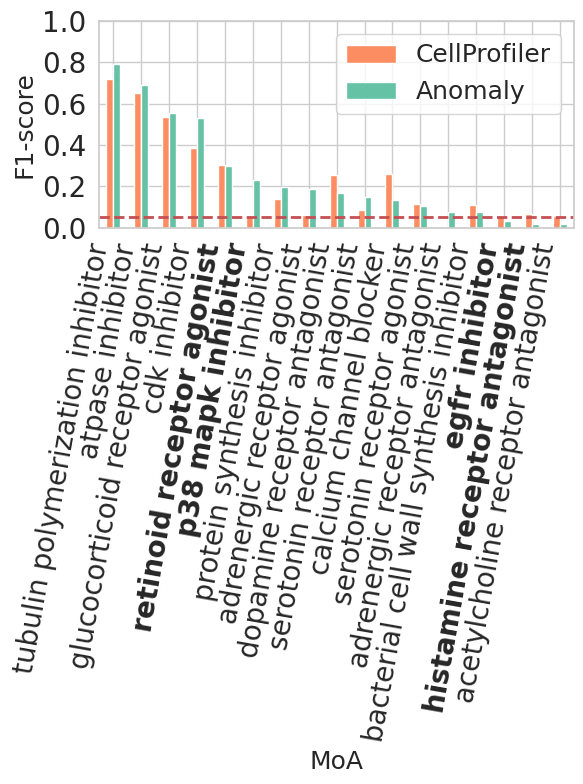

<Figure size 1000x600 with 0 Axes>

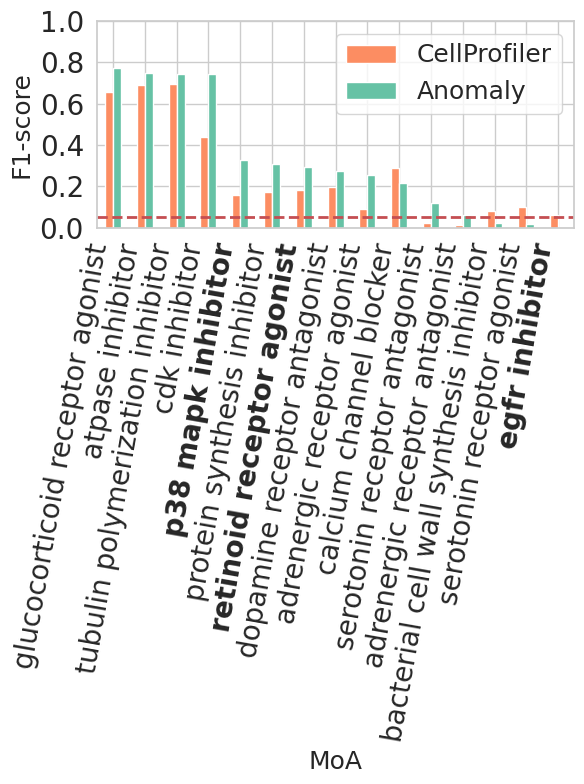

<Figure size 1000x600 with 0 Axes>

In [242]:
from sklearn.metrics import classification_report
from utils.global_variables import methods_colors_list_for_moa

with_fusion = False
added_show_thresh_val = 0

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:

    print(f'running for {model}')
    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'Anomaly' in k:
            rep = 'Anomaly'
        elif 'CellProfiler' in k:
            rep = 'CellProfiler'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        scores_model = saved_scores_cdrpbio[k]
        scores[rep] = scores_model['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())
    # # 2. reformat scores to be able to use classification report


    # scores_mlp = pd.concat(saved_scores_cdrpbio[mlp_keys])
    # scores_mlp=res_df[(res_df["Modality"]=="CP") & (res_df["Model"]=="MLP")]
    # scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

    # scor_vals_ae=scores_mlp['AE_pred'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_raw=scores_mlp['CellProfiler'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err=scores_mlp['Anomaly'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    if with_fusion:
        scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    if with_fusion:
        report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err.index[0:n_classes]:
        report_clss_ae_err.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err[0:n_classes]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    if with_fusion:
        report_clss3['f1-score-fuse']=report_clss_fuse.loc[report_clss3.index]['f1-score'].values
    # report_clss3['f1-score-ae_err']=report_clss_ae_err.loc[report_clss3.index]['f1-score'].values

    # report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
    # report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-ae_err']]
    if with_fusion:
        report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]
    else:
        report_clss4=report_clss3[['f1-score-raw','f1-score']]
        
    report_clss4=report_clss4.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly','f1-score-fuse':'Fusion'})
    report_clss4.index=report_clss3['MoA']

    rand_f1_score = (1/n_classes)/ ( (1-1/n_classes) + 1/n_classes + 1/n_classes)
    thresh = rand_f1_score + added_show_thresh_val
    print(f'n_classes: {len(report_clss4)}')
    report_clss5 = report_clss4[(report_clss4['CellProfiler']>=thresh) | (report_clss4['Anomaly']>=thresh)]
    print(f'number of classes with F1-score higher than random: {len(report_clss5)}')

    # ax = report_clss4.plot.bar(figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    if dataset == 'CDRP-bio':
        figsize_v = int(n_classes/3)
        h_size = 5.5
        fontsize =20
    else:
        if nSamplesMOA ==9:
            figsize_v = int(n_classes/3.5)
            h_size = 8
            fontsize =18
        else:
            figsize_v = int(n_classes/4.5)
            h_size = 8
            fontsize =18
    ax = report_clss5.plot.bar(figsize=(figsize_v,8),fontsize=fontsize,linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha='right')
    for i, label in enumerate(ax.get_xticklabels()):
        # print(label.get_text())
        if label.get_text() in new_classes:
            # print(label.get_text())
            # label.set_color('blue')
            label.set_fontweight('bold')
    
    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(figsize=(5,6.5),fontsize=15)

    # plt.title(f'{dataset} class specific F1-scores ({model})')
    plt.legend(loc='upper right', fontsize=18)
    plt.ylabel('F1-score', fontsize=18)
    plt.xlabel('MoA', fontsize=18)
    ax.set_ylim([0,1])
    ax.axhline(y=rand_f1_score,linestyle='--',color='r',linewidth=2)
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_dirname}.png')
    plt.savefig(save_path,dpi=500)
    # plt.close()

    # a graph showing the number of classes that pass the F1 threshold vs. the F1 threshold
    plt.figure(figsize=(10, 6))
    x = np.arange(0, 1, 0.05)

    do_plot = False
    if do_plot:
        # Plotting the graph
        plt.plot(x, [len(report_clss4[report_clss4['CellProfiler'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler')
        plt.plot(x, [len(report_clss4[report_clss4['Anomaly'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly')
        # plt.axhline(y=1/n_classes, color='red', linestyle='--')

        # Customize the plot
        plt.xlabel('F1 Threshold')
        plt.ylabel('Number of Classes')
        plt.title('Number of Classes Passing F1 Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(fig_dir, f'num_classes_passing_f1_threshold_{model}_{moa_csv_dirname}.png'), dpi=500)
    # if 1:
    #     source_data_add='../Figs_Source_Data.xlsx'
    #     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    #     # fig.tight_layout()
    #     plt.savefig('fig4c_1.pdf',dpi=500)

In [243]:
top_10_classes = report_clss4.sort_values(by='Anomaly', ascending=False).head(10)
list(top_10_classes.index)

['glucocorticoid receptor agonist',
 'atpase inhibitor',
 'tubulin polymerization inhibitor',
 'cdk inhibitor',
 'p38 mapk inhibitor',
 'protein synthesis inhibitor',
 'retinoid receptor agonist',
 'dopamine receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

In [244]:
print('Number of classes in representation 1 but not in representation 2: ', len(new_classes))
print('number of classes in with new filtering: ', n_classes)
print('number of classes in old filtering: ', n_classes_orig)

Number of classes in representation 1 but not in representation 2:  5
number of classes in with new filtering:  18
number of classes in old filtering:  13


In [245]:
f1_thresh = rand_f1_score
print(f'number of classes with F1 higher than {f1_thresh} for representation AE: {(report_clss_ae_err["f1-score"][:n_classes]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler: {(report_clss_raw["f1-score"][:n_classes]>f1_thresh).sum()}')
f1_thresh = rand_f1_score_ref
print(f'number of classes with F1 higher than {f1_thresh} for representation AE ref: {(report_clss_ae_err_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler ref: {(report_clss_raw_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')


number of classes with F1 higher than 0.05263157894736842 for representation AE: 12
number of classes with F1 higher than 0.05263157894736842 for representation CellProfiler: 13
number of classes with F1 higher than 0.07142857142857144 for representation AE ref: 8
number of classes with F1 higher than 0.07142857142857144 for representation CellProfiler ref: 9


In [246]:
# print number of classes with F1 higher than 0.2 for all representations
f1_thresh = 0.15
print(f'number of classes with F1 higher than {f1_thresh} for representation AE: {(report_clss_ae_err["f1-score"][:n_classes]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler: {(report_clss_raw["f1-score"][:n_classes]>f1_thresh).sum()}')

print(f'number of classes with F1 higher than {f1_thresh} for representation AE ref: {(report_clss_ae_err_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler ref: {(report_clss_raw_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')


number of classes with F1 higher than 0.15 for representation AE: 10
number of classes with F1 higher than 0.15 for representation CellProfiler: 9
number of classes with F1 higher than 0.15 for representation AE ref: 8
number of classes with F1 higher than 0.15 for representation CellProfiler ref: 6


In [247]:
# print number of classes with F1 higher than 0.2 for all representations
f1_thresh = 0.2
print(f'number of classes with F1 higher than {f1_thresh} for representation AE: {(report_clss_ae_err["f1-score"][:n_classes]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler: {(report_clss_raw["f1-score"][:n_classes]>f1_thresh).sum()}')

print(f'number of classes with F1 higher than {f1_thresh} for representation AE ref: {(report_clss_ae_err_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler ref: {(report_clss_raw_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')

number of classes with F1 higher than 0.2 for representation AE: 10
number of classes with F1 higher than 0.2 for representation CellProfiler: 5
number of classes with F1 higher than 0.2 for representation AE ref: 8
number of classes with F1 higher than 0.2 for representation CellProfiler ref: 5


In [248]:
report_clss_ae_err['f1-score']['weighted avg'], report_clss_raw['f1-score']['weighted avg'], report_clss_ae_err_ref['f1-score']['weighted avg'], report_clss_raw_ref['f1-score']['weighted avg']

(0.28094890765576774,
 0.2191306965190602,
 0.37807372548275187,
 0.3162110293885265)

In [249]:
# print F1 improvement for AE vs. CellProfiler per class
f1_improvement = report_clss_ae_err['f1-score'] - report_clss_raw['f1-score']
f1_improvement.mean(), f1_improvement.median(), f1_improvement.std()
# f1_improvement
f1_improvement_dict = {}
for i in range(0, len(f1_improvement)):
    f1_improvement_dict[report_clss_ae_err.MoA[i]] = f1_improvement[i]
    # print(f'F1 improvement for class {report_clss_ae_err.MoA[i]}: {f1_improvement[i]}')
f1_improvement_df = pd.DataFrame(f1_improvement_dict.items(), columns=['MoA', 'F1 improvement']).sort_values(by='F1 improvement', ascending=False)
f1_improvement_df.to_csv(os.path.join(fig_dir, 'f1_improvement_ae_vs_cp.csv'), index=False)
f1_improvement_df

,MoA,F1 improvement
6,cdk inhibitor,0.305656
1,adrenergic receptor agonist,0.167963
12,p38 mapk inhibitor,0.165581
13,protein synthesis inhibitor,0.135279
10,glucocorticoid receptor agonist,0.115430
14,retinoid receptor agonist,0.110317
16,serotonin receptor antagonist,0.097260
8,dopamine receptor antagonist,0.074758
18,,0.061818
3,atpase inhibitor,0.055784


In [250]:
scores_mlp['Metadata_moa_with_n'].unique()

array(['adrenergic receptor agonist (n=13)',
       'adrenergic receptor antagonist (n=9)',
       'calcium channel blocker (n=8)',
       'protein synthesis inhibitor (n=7)',
       'serotonin receptor agonist (n=10)', 'atpase inhibitor (n=8)',
       'dopamine receptor agonist (n=6)', 'p38 mapk inhibitor (n=5)',
       'bacterial cell wall synthesis inhibitor (n=5)',
       'acetylcholine receptor antagonist (n=5)',
       'dopamine receptor antagonist (n=18)',
       'histamine receptor antagonist (n=5)',
       'glucocorticoid receptor agonist (n=10)',
       'serotonin receptor antagonist (n=9)',
       'tubulin polymerization inhibitor (n=6)', 'egfr inhibitor (n=5)',
       'retinoid receptor agonist (n=5)', 'cdk inhibitor (n=5)'],
      dtype=object)

In [251]:
# produce figure only for those classes that are only in representation 1
report_clss_ae_err[~report_clss_ae_err.index.isin(report_clss_ae_err.index)]


,precision,recall,f1-score,support,MoA


In [252]:
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist']

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist']

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
# ax =report_clss4.loc[top_cdrp_lincs_overlap].plot.bar(rot=90,figsize=(6,6))
# ax.set_ylim([0,1])
# plt.title('MoA class specific F1-scores')
# plt.tight_layout()

In [253]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']/10

/tmp/ipykernel_222853/1068093572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['support']=report_clss2['support'].astype(int)
/tmp/ipykernel_222853/1068093572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['n_samples']=report_clss2['support']/10


In [254]:
scores_mlp

,Anomaly,CellProfiler,Fusion,Metadata_moa_num,Metadata_moa_with_n,Metadata_MoA
0,16,16,16,1,adrenergic receptor agonist (n=13),adrenergic receptor agonist
1,0,10,3,2,adrenergic receptor antagonist (n=9),adrenergic receptor antagonist
2,8,11,11,5,calcium channel blocker (n=8),calcium channel blocker
3,13,3,13,13,protein synthesis inhibitor (n=7),protein synthesis inhibitor
4,8,8,15,15,serotonin receptor agonist (n=10),serotonin receptor agonist
...,...,...,...,...,...,...
1385,8,15,8,16,serotonin receptor antagonist (n=9),serotonin receptor antagonist
1386,8,8,8,14,retinoid receptor agonist (n=5),retinoid receptor agonist
1387,8,4,4,2,adrenergic receptor antagonist (n=9),adrenergic receptor antagonist
1388,1,11,11,15,serotonin receptor agonist (n=10),serotonin receptor agonist


In [255]:
report_clss2

,precision,recall,f1-score,support,MoA,n_samples
0,0.000000,0.000000,0.000000,50,acetylcholine receptor antagonist,5.0
1,0.207547,0.338462,0.257310,130,adrenergic receptor agonist,13.0
2,0.065789,0.055556,0.060241,90,adrenergic receptor antagonist,9.0
3,0.960784,0.612500,0.748092,80,atpase inhibitor,8.0
4,0.029412,0.020000,0.023810,50,bacterial cell wall synthesis inhibitor,5.0
5,0.235294,0.200000,0.216216,80,calcium channel blocker,8.0
6,0.795455,0.700000,0.744681,50,cdk inhibitor,5.0
7,0.000000,0.000000,0.000000,60,dopamine receptor agonist,6.0
8,0.223404,0.350000,0.272727,180,dopamine receptor antagonist,18.0
9,0.000000,0.000000,0.000000,50,egfr inhibitor,5.0


/tmp/ipykernel_222853/3074831670.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


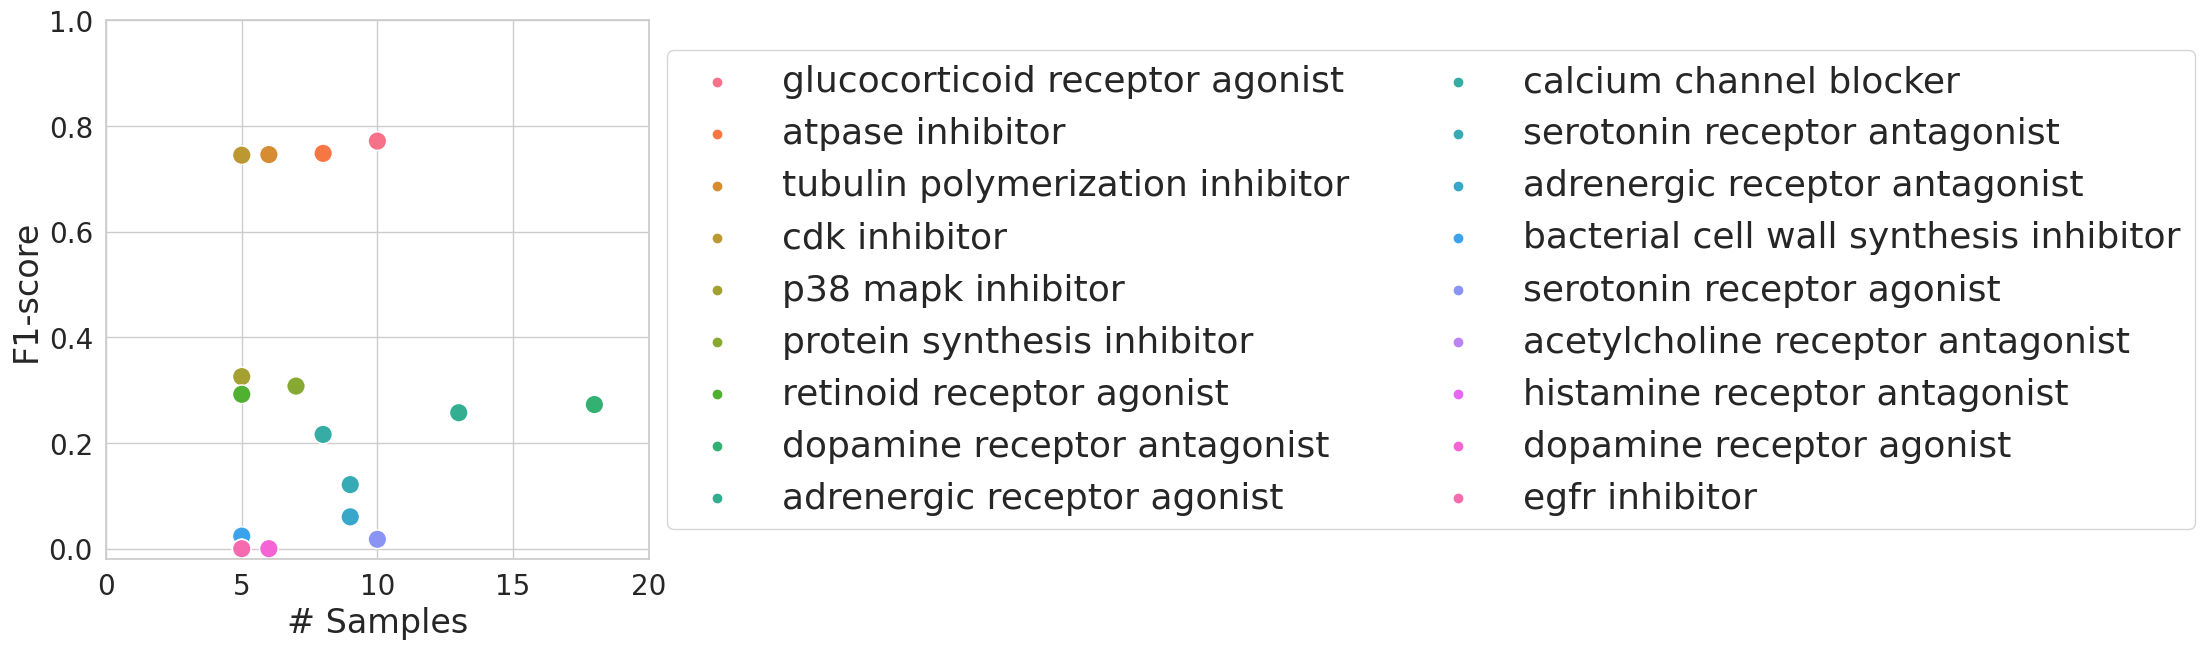

In [256]:


import matplotlib.style as style
style.use('seaborn-colorblind')
report_clss2=report_clss2.sort_values(by='f1-score',ascending=False)
# if dataset == 'CDRP-bio':
    # plt.figure(figsize=(3,8))
# else:
plt.figure(figsize=(7,7))
# plt.figure(figsize=(6,8))
sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=True, s= 180)

plt.xlabel('# Samples', fontsize=24)
plt.ylabel('F1-score', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)
if dataset == 'CDRP-bio':
    # plt.legend(loc='upper right', fontsize=7)
    # plt.xlabel('# Samples', fontsize=18)
    # plt.ylabel('F1-score', fontsize=18)
    # plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=26)

    plt.xlim([0,20])
    plt.ylim([-0.02,1])
else:
    # plt.legend(loc='upper right', fontsize=5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=26)
    plt.xlim([0,25])
    plt.ylim([-0.02,1])
plt.savefig(os.path.join(fig_dir, f'moa_class_scatter_{model}_{moa_csv_dirname}.png'), dpi=500, bbox_inches="tight")
# plt.tight_layout()# p
# plt.savefig('moa_class_scatter.eps')

In [257]:
# print F1 scores for ae_err and raw
report_clss_ae_err['f1-score']['weighted avg'], report_clss_raw['f1-score']['weighted avg'], report_clss_ae_err_ref['f1-score']['weighted avg'], report_clss_raw_ref['f1-score']['weighted avg']

(0.28094890765576774,
 0.2191306965190602,
 0.37807372548275187,
 0.3162110293885265)